In [95]:
%load_ext autoreload 
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import random
import numpy as np
import sys
import os
import sklearn.metrics as skm
os.chdir("/afs/cs.stanford.edu/u/awni/scr/ecg-master")
sys.path.append('./ecg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_path = "/deep/group/pranavsr/saved/default/1499315864-990/0.424-0.848-009-0.354-0.868.hdf5"

import load
import json
import util
import predict

params = util.get_model_params(model_path)
test_params = json.load(open('./configs/test.json', 'r'))
x_gt, gt, processor, dl = load.load_test(
            test_params,
            train_params=params,
            split='test')
probs = predict.get_model_pred_probs(model_path, x_gt)

0it [00:00, ?it/s]

Building blacklist...


336it [00:00, 1033.19it/s]
0it [00:00, ?it/s]

Contains 328 patients


64121it [00:21, 3011.89it/s]
  0%|          | 102/56378 [00:00<00:55, 1014.82it/s]

Contains 28835 patients
Constructing Training Set...


  1%|▏         | 88/6346 [00:00<00:07, 870.83it/s]

Constructing Test Set...


100%|██████████| 6346/6346 [00:07<00:00, 895.26it/s]


Relabelling Classes...
Fitting Normalization: robust_scale


./ecg/featurize.py:16: UserWarning: Expanding Dimensions...
  warnings.warn("Expanding Dimensions...")


Applying Normalization...
Applying Normalization...


0it [00:00, ?it/s]

Length of training set 56378
Length of test set 6346
Loading using processor...


336it [00:00, 740.75it/s]
0it [00:00, ?it/s]
  4%|▍         | 14/336 [00:00<00:02, 136.85it/s]

Contains 328 patients
Constructing Training Set...
Constructing Test Set...


100%|██████████| 336/336 [00:02<00:00, 144.62it/s]
Using TensorFlow backend.


Relabelling Classes...
Applying Normalization...
Length of training set 0
Length of test set 336
Size: 336 examples.
336/336 [==============================] - 6s     


In [16]:
gts = gt.squeeze()
preds = np.argmax(probs, axis=-1)
c_report = skm.classification_report(gts.ravel(), preds.ravel(), target_names=processor.classes, digits=3)
print c_report
def roc_auc(gts, probs, index):
    n_gts = np.zeros_like(gts)
    n_gts[gts==index] = 1
    n_ps = probs[:,:,index].squeeze()
    n_gts, n_ps = n_gts.ravel(), n_ps.ravel()
    return skm.roc_curve(n_gts, n_ps, pos_label=1), skm.roc_auc_score(n_gts, n_ps)

cnf = skm.confusion_matrix(gts.ravel(), preds.ravel())
cat_classes = [c[:4] for c in processor.classes]
t_cnf = np.hstack([np.array(cat_classes)[:,None], cnf])
print tabulate(t_cnf, headers=[''] + cat_classes)
print "AUC Scores"
for idx, cname in processor.int_to_class.items():
   print "{: <8}\t{:.3f}".format(cname, roc_auc(gts, probs, idx)[1])

             precision    recall  f1-score   support

       AFIB      0.838     0.458     0.592       642
        AFL      0.536     0.973     0.691       369
  AVB_TYPE2      0.684     0.679     0.681       364
   BIGEMINY      0.905     0.884     0.895       216
        CHB      0.814     0.846     0.830       487
        EAR      0.613     0.457     0.523       256
        IVR      0.836     0.626     0.716       195
 JUNCTIONAL      0.873     0.530     0.659       570
      NOISE      0.919     0.747     0.824       605
      SINUS      0.821     0.941     0.877      3034
        SVT      0.597     0.380     0.464       308
  TRIGEMINY      0.866     0.956     0.909       251
         VT      0.366     0.872     0.516        47
 WENCKEBACH      0.701     0.714     0.707       384

avg / total      0.793     0.780     0.771      7728

        AFIB    AFL    AVB_    BIGE    CHB    EAR    IVR    JUNC    NOIS    SINU    SVT    TRIG    VT    WENC
----  ------  -----  ------  ------  --

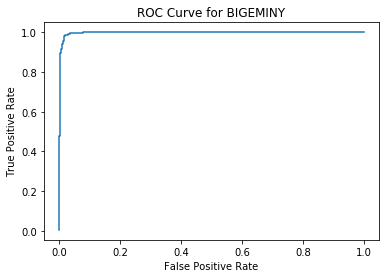

In [58]:
idx = 3
fp, tp, _ = roc_auc(gts, probs, idx)[0]
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for {}".format(processor.classes[idx]))

In [119]:
#test_dir = "/deep/group/med/irhythm/ecg/clean_30sec_recs/label_review/CARDIOL_MAY_2017"
#%matplotlib notebook
gt_name = "SVT"
p_name = "SINUS"
def get_all(gt_name, p_name):
    gt_idx = processor.classes.index(gt_name)
    p_idx = processor.classes.index(p_name)
    p_idxs = np.unique(np.where(np.logical_and(preds==p_idx,gt==gt_idx))[1])
    print gt.shape
    return x_gt[p_idxs,:].squeeze(), preds[p_idxs,:], gt[:,p_idxs,:].squeeze(), recs[p_idxs]
ecgs,prx,gtx,precs = get_all(gt_name, p_name)
ind = 0
#plt.plot(ecgs[ind])
print "Model", " ".join(processor.int_to_class[p] for p in prx[ind])
print "Group", " ".join(processor.int_to_class[p] for p in gtx[ind,:])
print precs[ind]

 (1, 336, 23)
Model SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS SVT SVT SVT SVT SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS
Group SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS SVT SVT SVT SVT SVT SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS SINUS
data/label_review/CARDIOL_MAY_2017/27e6769960612a2c65ced7185fa0656c_0002.ecg


In [6]:
# Human perf
import human_performance as hp
h_gt, h_probs = hp.human_gt_and_probs(test_params, x_gt, gt, processor)

0it [00:00, ?it/s]

Loading using processor...


336it [00:00, 1011.65it/s]
0it [00:00, ?it/s]
 46%|████▌     | 154/336 [00:00<00:00, 1527.80it/s]

Contains 328 patients
Constructing Training Set...
Constructing Test Set...


100%|██████████| 336/336 [00:00<00:00, 1222.61it/s]


Relabelling Classes...
Applying Normalization...
Length of training set 0
Length of test set 336
Size: 336 examples.


336it [00:00, 7516.43it/s]
0it [00:00, ?it/s]
 35%|███▌      | 118/336 [00:00<00:00, 1178.81it/s]

Loading using processor...
Contains 328 patients
Constructing Training Set...
Constructing Test Set...


100%|██████████| 336/336 [00:00<00:00, 1268.82it/s]


Relabelling Classes...
Applying Normalization...
Length of training set 0
Length of test set 336
Size: 336 examples.


336it [00:00, 6637.18it/s]
0it [00:00, ?it/s]
 54%|█████▍    | 181/336 [00:00<00:00, 1803.83it/s]

Loading using processor...
Contains 328 patients
Constructing Training Set...
Constructing Test Set...


100%|██████████| 336/336 [00:00<00:00, 1789.62it/s]


Relabelling Classes...
Applying Normalization...
Length of training set 0
Length of test set 336
Size: 336 examples.


336it [00:00, 7482.63it/s]
0it [00:00, ?it/s]
 36%|███▌      | 121/336 [00:00<00:00, 1199.17it/s]

Loading using processor...
Contains 328 patients
Constructing Training Set...
Constructing Test Set...


100%|██████████| 336/336 [00:00<00:00, 1185.10it/s]


Relabelling Classes...
Applying Normalization...
Length of training set 0
Length of test set 336
Size: 336 examples.


336it [00:00, 6962.70it/s]
0it [00:00, ?it/s]
 53%|█████▎    | 179/336 [00:00<00:00, 1783.95it/s]

Loading using processor...
Contains 328 patients
Constructing Training Set...
Constructing Test Set...


100%|██████████| 336/336 [00:00<00:00, 1792.12it/s]


Relabelling Classes...
Applying Normalization...
Length of training set 0
Length of test set 336
Size: 336 examples.


336it [00:00, 6363.41it/s]
0it [00:00, ?it/s]
 58%|█████▊    | 194/336 [00:00<00:00, 1932.08it/s]

Loading using processor...
Contains 328 patients
Constructing Training Set...
Constructing Test Set...


100%|██████████| 336/336 [00:00<00:00, 1904.57it/s]


Relabelling Classes...
Applying Normalization...
Length of training set 0
Length of test set 336
Size: 336 examples.


In [9]:
from tabulate import tabulate
h_ps = np.argmax(h_probs, axis=2)
c_report = skm.classification_report(h_gt.ravel(), h_ps.ravel(), target_names=processor.classes, digits=3)
print c_report
cnf = skm.confusion_matrix(h_gt.ravel(), h_ps.ravel())
cat_classes = [c[:4] for c in processor.classes]
t_cnf = np.hstack([np.array(cat_classes)[:,None], cnf])
print tabulate(t_cnf, headers=[''] + cat_classes)

             precision    recall  f1-score   support

       AFIB      0.495     0.537     0.515      3852
        AFL      0.600     0.674     0.635      2214
  AVB_TYPE2      0.519     0.556     0.537      2184
   BIGEMINY      0.845     0.829     0.837      1296
        CHB      0.806     0.620     0.701      2922
        EAR      0.636     0.380     0.476      1536
        IVR      0.654     0.611     0.632      1170
 JUNCTIONAL      0.757     0.624     0.684      3420
      NOISE      0.788     0.749     0.768      3630
      SINUS      0.803     0.898     0.847     18204
        SVT      0.500     0.408     0.449      1848
  TRIGEMINY      0.859     0.828     0.843      1506
         VT      0.500     0.652     0.566       282
 WENCKEBACH      0.661     0.539     0.593      2304

avg / total      0.723     0.724     0.719     46368

        AFIB    AFL    AVB_    BIGE    CHB    EAR    IVR    JUNC    NOIS    SINU    SVT    TRIG    VT    WENC
----  ------  -----  ------  ------  --